# Epidemic mitigation project

In [1]:
# Install gym version 0.26.2 on the server
!pip install gym==0.26.2

In [1]:
from gym import spaces
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

import numpy as np
# All additional imports for the NN part
from collections import namedtuple, deque
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import random
import seaborn as sns
import pandas as pd
import pickle

SEED = 1337
random.seed(SEED)
torch.manual_seed(SEED)
# TODO write why we cannot do this!
#torch.use_deterministic_algorithms(True)

%matplotlib inline

## Question 1 No actions

### Question 1.a)
Implementing the unmitigated agent

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities)
#dyn.draw_map()

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


In [3]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"Number cities: {dyn.n_cities} and env_step_length: {dyn.env_step_length}")
print(f"sampled action : {action_space.sample()}")
print(f"Sampled observation (shape {observation_space.sample().shape}) first dimension is infected & dead")
#plt.matshow(observation_space.sample()[0,:,:])
#plt.show()

Number cities: 9 and env_step_length: 7
sampled action : 0
Sampled observation (shape (2, 9, 7)) first dimension is infected & dead


In [4]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    obvSpace = torch.Tensor(np.stack((infected, dead))).unsqueeze(0)
    return obvSpace

In [5]:
env_1 = Env(dyn,
            action_space=action_space,
            observation_space=observation_space,
            observation_preprocessor=observation_preprocessor,
            action_preprocessor=action_preprocessor
        )

In the following cell we show how to subclass the agent class. (Here to create a fully random dummy agent with 5 actions).

In [6]:
class UnmitigatedAgent(Agent):
    def __init__(self,  env:Env):
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # The unmitigated agent always takes the same action, i.e. do nothing
        return ACTION_NULL

#### Running with this agent

In [7]:
def run_episode_simulation_simple(agent,env,seed):
    """ Run the simulation """
    log = []
    finished = False
    obs, info = env.reset(seed)
    torch.manual_seed(seed)
    deaths = []
    rewards = []
    agent.reset()
    agent.epsilon = 0
    while not finished:
        # Each action is done per week
        action = agent.act(obs)
        # Meaning also the log info is per week
        obs, R, finished, info = env.step(action)
        deaths.append(info.total.dead)
        rewards.append(R)
        log.append(info) # save the information dict for logging

    """ Parse the logs """
    deaths = np.array(deaths)
    rewards = np.array([r.squeeze() for r in rewards])
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    return deaths, rewards, total, cities, actions

In [8]:
agent = UnmitigatedAgent(env_1)
deaths, rewards, total, cities, actions = run_episode_simulation_simple(agent,env_1,SEED)

1. A plot of variables s e i r d per week total over time, where time is measured in weeks and all the variables share the y axis scaling.

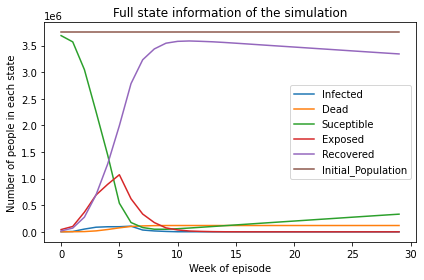

In [9]:
def plt_state(total):
    [plt.plot(y) for y in total.values()]
    plt.legend([k.title() for k in total.keys()])
    plt.title('Full state information of the simulation')
    plt.ylabel('Number of people in each state')
    plt.xlabel('Week of episode')
    plt.tight_layout()
    plt.show()

plt_state(total)

TODO check okay

Discuss the variables over time:

As expected from not doing anything to counter the spread of a pandemic, the amount of people that are exposed and infected with the virus steadily increases over the first roughly seven weeks, while the amount of susceptible people decreases during the same time.
The amount of exposed people starts to decrease again because there are less people susceptible at around week seven or eight, but the amound of recovered people keeps increasing even after because there are still infected people.
Although it is not clearly visible from the sizing of the graph, the amount of infected and hence also dead people similarly steadily increases until there are not many people left that could get the virus around week five and that could die at around week eight.

2. A plot of variables i d total over time, where time is measured in weeks and all the variables share the y axis scaling.

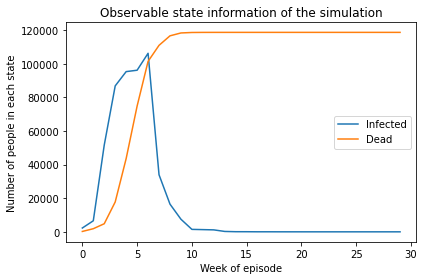

In [10]:
def plt_obs(total):
    [plt.plot(total[y]) for y in ['infected','dead']]
    plt.legend(['Infected','Dead'])
    plt.title('Observable state information of the simulation')
    plt.ylabel('Number of people in each state')
    plt.xlabel('Week of episode')
    plt.tight_layout()
    plt.show()

plt_obs(total)

TODO check okay
Discuss the variables over time:

From the observable state it is also rather clear that not doing any prevention leads to a very rapid increase in the amount of infected people, which directly leads to a sharp increase in deaths with a delay to the infections.
Similarly we can see that in this simulation the amount of infected (and in the background sensibly those suceptible) are exhauted at some point and there are not many new infections.
This leads to believe that within this simulation across 30 weeks, people do not return to being suceptible.

3. A set of plots of variables i d city over time, where time is measured in weeks (one subplot per-city, variables share the y-scaling per-city).

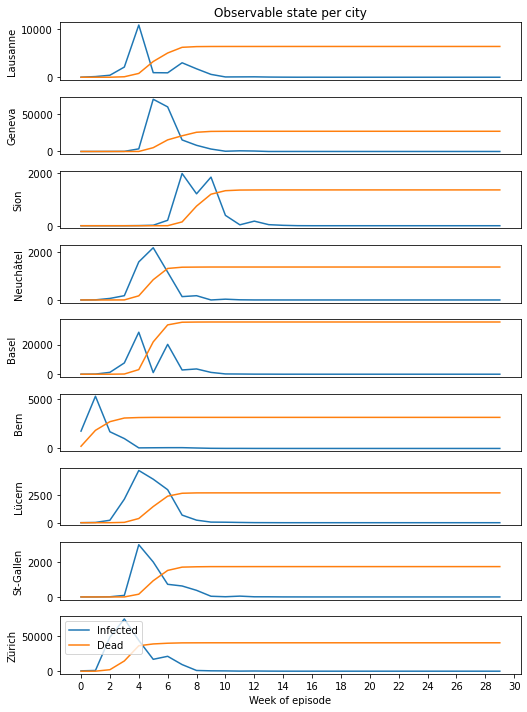

In [11]:
# No modification necessary from the tutorial code
def plt_per_city(cities):
    fig = plt.figure(figsize=(14, 10))
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('Week of episode')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))
    ax_right['Lausanne'].set_title('Observable state per city')
    plt.legend(['Infected','Dead'])
    fig.tight_layout()
    plt.show()

plt_per_city(cities)

TODO check okay
Discuss the variables over time!

Very similar to the plot before of the total infected and dead, we see that the amount of infected increases sharply in each city after the first infectious people arrive in the city.
Similarly we see again that the amount of dead people increases similarly fast within two to three weeks to its near maximum, but with an offset of a week or two to when people got infected.
Interestingly, in Basel in this run of the simulation the infection stopped spreading at around week three, but within a week later restarted with the same speed of spread.

## Question 2 Professor Russo's policy

### Question 2.a)

#### Implementing this policy
We do not need the obvservation space preprocessor in that case, but can reuse the action preprocessor.

In [13]:
env_2 = Env(dyn,
            action_space=None,
            observation_space=None,
            action_preprocessor=action_preprocessor)

In [14]:
class RussoAgent(Agent):
    def __init__(self,  env:Env):
        self.env = env
        # Number of weeks until quarantine ends
        self.quarantine_weeks = 0  

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        self.quarantine_weeks = 0
    
    def act(self, obs):
        # The unmitigated agent always takes the same action, i.e. do nothing
        if self.quarantine_weeks > 0:
            self.quarantine_weeks -= 1
            return ACTION_CONFINE
        elif obs.total.infected[-1] > 20_000:
            self.quarantine_weeks = 4
            return ACTION_CONFINE
        return ACTION_NULL

#### Running with Russo's agent

In [15]:
agent = RussoAgent(env_2)
deaths, rewards, total, cities, actions = run_episode_simulation_simple(agent,env_2,SEED)

1. A plot of variables s e i r d per week total over time, where time is measured in weeks and all the variables share the y axis scaling.

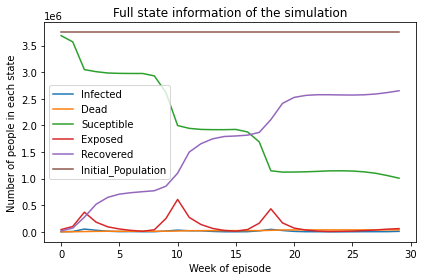

In [16]:
plt_state(total)

TODO check okay
Discuss how the simulation reponds to this policy (focusing on how it differs from the unmitigated scenario):

We can clearly see from the amount of people that are exposed, that doing a confinment reduces the speed at which the virus spreads.
This impact can also be seen for both the amount of suceptible and recovered people in the state of the simulation, which both flatten out whenever Russo's policy confines people.

2. A plot of variables i d total over time, where time is measured in weeks and all the variables share the y axis scaling.

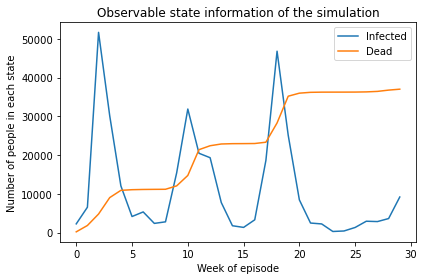

In [17]:
plt_obs(total)

TODO check okay
Discuss how the simulation reponds to this policy (focusing on how it differs from the unmitigated scenario):

Looking at only the observable state we can again clearly see the three waves that Russo's policy creates within those 30 weeks.
Whenever a new confinement is enacted the amount of infected people sharply decreases for roughly four weeks, while the deaths do not increase for a similar period but again delayed by up to two weeks.


3. A set of plots of variables i d city over time, where time is measured in weeks (one subplot per-city, variables share the y-scaling per-city).

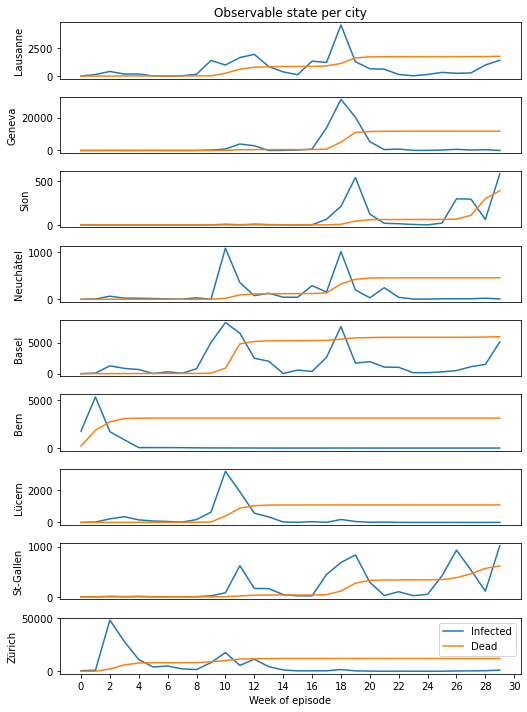

In [18]:
plt_per_city(cities)

TODO check okay
Discuss how the simulation reponds to this policy (focusing on how it differs from the unmitigated scenario):

Looking at the observable state per city we can see that there is neither one nor three waves per city, but rather that most cities have multiple (up to four) smaller waves compared to no confinement.
Additionally, we see that because Russo's policy looks at at the amount of total infected people that for example Bern has a strong increase in infected but because there are not enough infected to start confinement, they have a very delayed response from Russo's policy (i.e. only once in addition there are enough infected in Zurich).

4. A plot of the action taken by the policy over time (whether the policy choooses to confine or not)

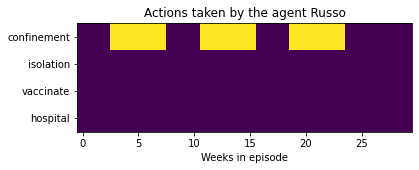

In [19]:
def plt_actions(actions, agentname):
    plt.figure(figsize=(6, 2))
    plt.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    plt.title(f'Actions taken by the agent {agentname}')
    plt.yticks([0,1,2,3], list(actions.keys()))
    plt.xlabel('Weeks in episode')
    plt.show()

plt_actions(actions, agentname='Russo')

The yellow fields show the weeks during which confinement is in effect.

TODO check okay
Discuss how the simulation reponds to this policy:

When looking at the policy decision we nicely see the three times confinement was activated, which resulted in the three waves of infections in the total state graph seen above.

### Question 2.b)
Evaluate Pr. Russo's policy

#### Multiple simulations
Running a suimulation of 50 enviroments  

In [45]:
def simulation(agent,env,n):
    info = []
    for i in range(n):
        # Run the agent with seed i, returns deaths, rewards, total, cities, actions
        info.append(run_episode_simulation_simple(agent,env,SEED+i))
    return info

def hist_plot(agent, env, n=50):
    info = simulation(agent,env,n)

    # process simulations
    conf_days = [np.sum(c[4]["confinement"])*7 for c in info]
    rewards = [np.array(np.sum(c[1])) for c in info]
    deaths = [d[0][-1] for d in info] 

    # Plot the histograms
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    def hist_avg(ax, data,title):
        ymax = 50
        if title == 'deaths':
            x_range = (1000,200000)
        elif title == 'cumulative rewards': 
            x_range = (-300,300)
        elif 'days' in title:
            x_range = (0,200)
        else:
            raise ValueError(f'{title} is not a valid title') 
        ax.set_title(title)
        ax.set_ylim(0,ymax)
        ax.vlines([np.mean(data)],0,ymax,color='red')
        ax.hist(data,bins=60,range=x_range)
    hist_avg(ax[0], deaths, 'deaths')
    hist_avg(ax[1], rewards, 'cumulative rewards')
    hist_avg(ax[2], conf_days, 'confined days')
    fig.tight_layout()
    plt.show()

    # Also print for quicker inspection
    print(f'Average death number: {np.mean(deaths)}')
    print(f'Average cumulative reward: {np.mean(rewards)}')
    print(f'Average number of confined days: {np.mean(conf_days)}')

#### Plot the 50 simulations for Russo's policy
Three histograms for the number of confined days, cumulative reward and total deaths.

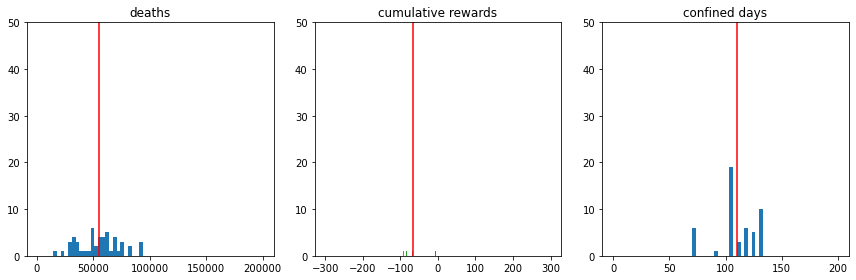

Average death number: 55124.54
Average cumulative reward: -66.52558898925781
Average number of confined days: 110.32


In [23]:
agent = RussoAgent(env_2)
hist_plot(agent,env_2,n=50)

## Question 3 Deep Q learning

In [20]:
# Parameters given by the assignment
# TODO maybe try some hyperparameter tuning after we know the DQN works
LR = 5*10**-3   # learning rate
DF = 0.9        # discount factor
MS = 20_000     # memory size
BS = 2048       # batch size

update_every = 5    # episodes
episodes = 500      # total episodes
average_over = 3    # when training plot the average over this many episodes

In [21]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### DQN with binary action space
New action space is necessary:

In [58]:
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
        
    return action

# Added the to(device)
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    obvSpace = torch.Tensor(np.stack((infected, dead))).to(device).unsqueeze(0)
    return obvSpace

In [59]:
action_space        =   spaces.Discrete(2)
print(f"sampled action : {action_space.sample()}")

sampled action : 1


In [60]:
env_3 = Env(dyn,
            action_space=action_space,
            observation_space=observation_space,
            observation_preprocessor=observation_preprocessor,
            action_preprocessor=action_preprocessor
        )

### Question 3.a)
Simple DQN with static epsilon.

In [61]:
# Utility function used later
def flatten(l):
    return [item for sublist in l for item in sublist]

In [62]:
# Saving traces function to plot them together later
def save_trace(name, combined):
    with open(name, 'wb') as f:
        pickle.dump(combined, f)

# Load such traces
def load_trace(name):
    with open(name, 'rb') as f:
        combined = pickle.load(f)
        return combined

#### Implementing the DQN agent

In [63]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [64]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        # Layers as defined in the handout
        self.input = nn.Linear(n_observations, 64)
        self.layer1 = nn.Linear(64, 32)
        self.layer2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x**0.25         # The sqrt 4th as suggested in the handout
        x = self.flatten(x)
        x = F.relu(self.input(x))
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)

In [65]:
class DQNagent(Agent):
    def __init__(self,  env:Env, eps=0.7):
        self.env = env
        self.n_observations = spaces.utils.flatdim(env.observation_space)
        self.n_actions = env.action_space.n
        self.dqnQtheta = DQN(self.n_observations, self.n_actions).to(device)
        self.dqnQhat = DQN(self.n_observations, self.n_actions).to(device)
        self.dqnQhat.load_state_dict(self.dqnQtheta.state_dict())
        self.memory = ReplayMemory(MS)
        self.optimizer = optim.AdamW(self.dqnQtheta.parameters(), lr=LR, amsgrad=True)
        self.epsilon = eps

    def load_model(self, savepath):
        loaded_state_dict = torch.load(savepath)    
        self.dqnQtheta.load_state_dict(loaded_state_dict)
        self.dqnQhat.load_state_dict(loaded_state_dict)

    def save_model(self, savepath):
        torch.save(self.dqnQtheta.state_dict(), savepath)
        
    # Following alg. 1 in https://arxiv.org/pdf/1312.5602.pdf
    def optimize_model(self,):
        # Heavily based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
        if len(self.memory) < BS:
            return
        transitions = self.memory.sample(BS)
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).to(device)

        # Compute  Q_sigma(sj, aj) for all states.
        state_action_values = self.dqnQtheta(state_batch).gather(1, action_batch)

        # Compute rj + DF * max_a' Q_hat(sj+1, a') for all non-final states,
        # for all final states values are 0
        next_state_values = torch.zeros(BS, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.dqnQhat(non_final_next_states).max(1)[0]
        next_state_values = next_state_values.unsqueeze(1)
        expected_state_action_values = reward_batch + (DF * next_state_values)

        # Compute Huber loss (we are allowed to use it)
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model, where we update Q_0 & Q_hat at the same time
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping; we are not supposed to do this, but it works great
        #torch.nn.utils.clip_grad_value_(self.dqnQtheta.parameters(), 100)
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        torch.manual_seed(SEED)
    
    def act(self, obs):
        # eps greedy choosing
        if random.random() < 1 - self.epsilon:
            # Exploitation
            with torch.no_grad():
                # The unmitigated agent always takes the same action, i.e. do nothing
                containment = self.dqnQtheta(obs.unsqueeze(0)) # flatten not necessary bc of nn.Flatten
                # max(1) returns lagest column vector per row, [1] of that the index of it 
                return containment.max(1)[1].view(1, 1)
        else:
            # Exploration
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

In [66]:
# Runs the agent over one episode
def run_episode(agent, env, seed, soft_update=False):
    finished = False
    obs, _ = env.reset(seed)
    torch.manual_seed(seed)
    rewards = []
    while not finished:
        # Each action is done per week
        action = agent.act(obs)
        new_obs, R, finished, _ = env.step(action)
        rewards.append(R)
        # If terminal => no next state exits
        next_obs = None if finished else new_obs
        # Save to replay buffer
        agent.memory.push(obs, action, next_obs, R)
        # Move to the next state
        obs = next_obs
        # Optimize the model
        agent.optimize_model()
            
    return np.sum([r.numpy()[0] for r in rewards])

In [67]:
# best eval global to keep the best model over all training runs
best_eval_reward = -np.inf

def evaluate_agent(agent, env, seed, agent_name, eval_episodes=20, save_best=True):
    last_eps = agent.epsilon
    agent.dqnQtheta.eval()
    agent.epsilon = 0
    eval_rewards = []
    for i in range(eval_episodes):
        eval_rewards.append(run_episode(agent, env, seed*i))
    mean_eval_reward = np.mean(eval_rewards)
    agent.epsilon = last_eps
    agent.dqnQtheta.train()
    # check if this is the best reward and if so save the model
    global best_eval_reward
    if save_best and mean_eval_reward > best_eval_reward:
        best_eval_reward = mean_eval_reward
        agent.save_model(savepath=f"{agent_name}_best_model.mdl")
        print(f"Best model updated with mean eval reward: {mean_eval_reward:.2f}")
    return mean_eval_reward

In [68]:
def run_simulation(agent,env,seed,agent_name):
    """ Run the simulation """
    training_trace = []
    eval_trace = []
    agent.reset()
    for i in range(episodes):
        print(f"Episode {i+1:3}/{episodes} ({i*100/episodes:.2f}%)", end="\r")
        reward = run_episode(agent, env, seed=seed+i)
        training_trace.append(reward)
        if i % update_every == 0:
            # Update the target network fully, copying all weights and biases
            agent.dqnQhat.load_state_dict(agent.dqnQtheta.state_dict())
        if (i % 50 == 0 or i == episodes-1) and i != 0:
            # run eval 20 episodes average with epsilon of 0
            mean_eval_reward = evaluate_agent(agent, env, seed+i, agent_name=agent_name, eval_episodes=20)
            print(f"Episode {i+1:3}/{episodes} ({i*100/episodes:.2f}%) - eval reward: {mean_eval_reward:.2f}")
            eval_trace.append(mean_eval_reward)

    return training_trace, eval_trace

In [202]:
# Eval trace averaged over n runs, training_trace can be used together
best_eval_reward = -np.inf
training_trace, eval_trace = list(zip(*[run_simulation(DQNagent(env_3),env_3,SEED,agent_name="Q3a") for _ in range(average_over)]))

Best model updated with mean eval reward: -169.87
Episode  51/500 (10.00%) - eval reward: -169.87
Best model updated with mean eval reward: -157.61
Episode 101/500 (20.00%) - eval reward: -157.61
Episode 151/500 (30.00%) - eval reward: -167.90
Best model updated with mean eval reward: -125.83
Episode 201/500 (40.00%) - eval reward: -125.83
Best model updated with mean eval reward: -7.10
Episode 251/500 (50.00%) - eval reward: -7.10
Best model updated with mean eval reward: 5.00
Episode 301/500 (60.00%) - eval reward: 5.00
Best model updated with mean eval reward: 28.60
Episode 351/500 (70.00%) - eval reward: 28.60
Episode 401/500 (80.00%) - eval reward: 25.76
Best model updated with mean eval reward: 28.98
Episode 451/500 (90.00%) - eval reward: 28.98
Episode 500/500 (99.80%) - eval reward: 25.84
Episode  51/500 (10.00%) - eval reward: -14.85
Episode 101/500 (20.00%) - eval reward: -157.61
Episode 151/500 (30.00%) - eval reward: -159.64
Episode 201/500 (40.00%) - eval reward: -9.06
Epi

In [33]:
def create_combined(training_traces, eval_trace, exploration="Decreasing"):
    eval_trace = np.mean(eval_trace, axis=0)
    combined = pd.concat([
        pd.DataFrame({
            "Episode": range(int(len(training_trace))),
            "Reward": training_trace,
            "Trace": ["Training" for _ in range(len(training_trace))],
            "Exploration": [exploration for _ in range(len(training_trace))],
            "Training run": f"Run {int(i+1):1}"
        }) for i, training_trace in enumerate(training_traces)] + [
        pd.DataFrame({
            "Episode": [50 * (i+1) for i in range(len(eval_trace))],
            "Reward": eval_trace,
            "Trace": ["Evaluation" for _ in range(len(eval_trace))],
            "Exploration": [exploration for _ in range(len(eval_trace))],
            "Training run": "Evaluation"
        })
    ])
    return combined

In [34]:
def plt_combined(combined, title):
    colors = ['#ff6961', '#42d6a4', '#ffb480',  '#59adf6', '#f8f38d', '#08cad1', '#9d94ff', '#c780e8']
    colors = colors[:len(combined[combined['Training run'] != "Evaluation"]['Training run'].unique())]
    ax = sns.scatterplot(data=combined[combined['Training run'] != "Evaluation"], x="Episode", y="Reward", hue="Training run", palette=colors, alpha=0.35)
    ax2 = sns.scatterplot(data=combined[combined['Training run'] == "Evaluation"], x="Episode", y="Reward", hue="Trace", alpha=1.0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

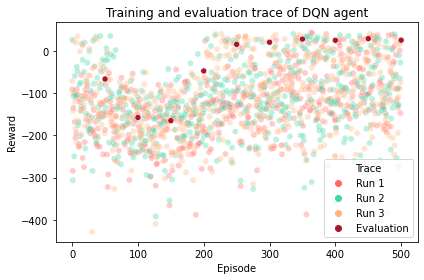

In [205]:
combined_a = create_combined(training_trace, eval_trace, exploration="Fixed")
save_trace('Q3a-trace.pickle', combined_a)
plt_combined(combined_a, "Training and evaluation trace of DQN agent")

TODO check
Does your agent learn a meaningful policy?

This agent clearly learns a policy as can be seen by the increas in the evalation trace.
It does so even rather quickly up to very close to the best policy that is found within the first 150 episodes of learning. 

Record three example episodes with best policy and plot one of them.

In [69]:
def run_episode_simulation(agent,env,seed):
    """ Run the simulation """
    agent.dqnQtheta.eval()
    agent.epsilon = 0
    agent.reset()
    finished = False
    obs, _ = env.reset(seed)
    rewards = []
    deaths = []
    log = []
    while not finished:
        # Each action is done per week
        action = agent.act(obs)
        new_obs, R, finished, info = env.step(action)
        # Log this step
        deaths.append(info.total.dead)
        rewards.append(R)
        log.append(info) # save the information dict for logging
        # If terminal => no next state exits
        next_obs = None if finished else new_obs
        # Move to the next state
        obs = next_obs
    
    """ Parse the logs """
    deaths = np.array(deaths)
    rewards = np.array([r.squeeze() for r in rewards])
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    return deaths, rewards, total, cities, actions

In [70]:
agent = DQNagent(env_3)
agent.load_model("Q3a_best_model.mdl")
three_example_episodes = [run_episode_simulation(agent,env_3,SEED+i) for i in range(average_over)]

Choose one of the example episodes and plot the results

In [71]:
# Single plot
# TODO should we also use this one for 2a)?
def plt_toghether(total, cities, actions): 
    fig = plt.figure(figsize=(14, 10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend([t.title() for t in total.keys()])
    ax_leftstate.set_title('Full state information of the simulation')
    ax_leftstate.set_ylabel('Number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['Infected','Dead'])
    ax_leftobs.set_title('Observable state information of the simulation')
    ax_leftobs.set_ylabel('Number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    ax_leftactions.set_title('Actions taken by the agent')
    ax_leftactions.set_yticks([0,1,2,3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('Weeks in episode')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('Weeks in episode')
    ax_right['Zürich'].xaxis.set_major_locator(ticker.MultipleLocator(2.000))
    ax_right['Lausanne'].set_title('Observable state per city')

    fig.tight_layout()
    fig.tight_layout()
    plt.show()

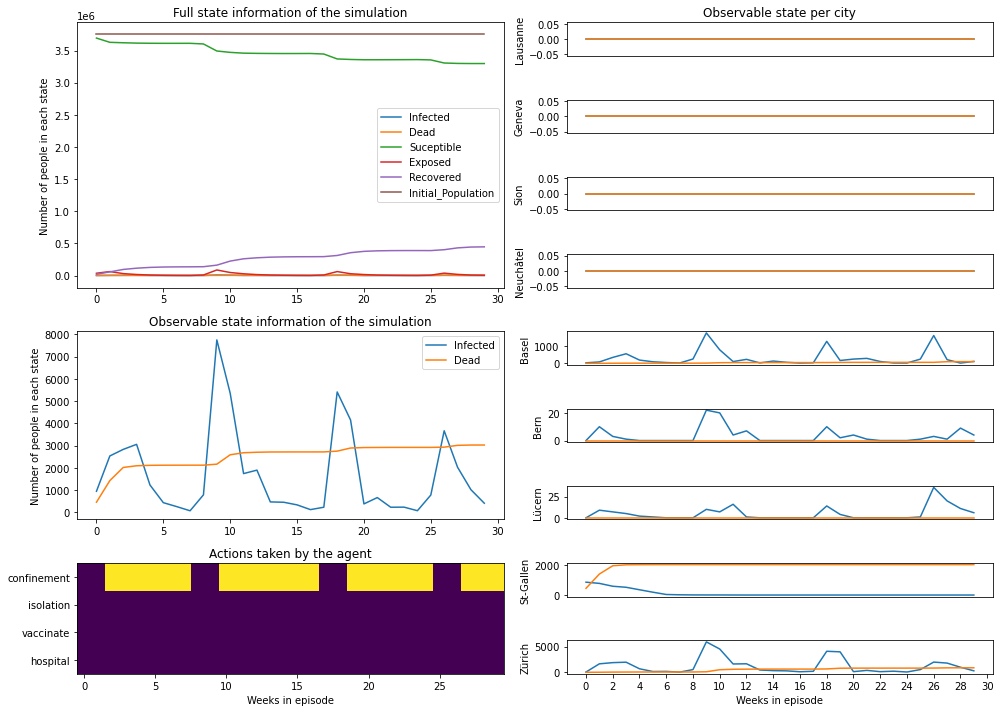

In [77]:
_, _, total, cities, actions = three_example_episodes[1]
plt_toghether(total, cities, actions)

TODO check okay
Interpret this policy.

From looking at a few full episodes using this policy, it seems that this agent confines whenever the infected amount reaches a threshould of around 1000 people and then confines them for quite some time.
How long this confinement lasts, or better under which condition it is lifted, is not directly clear.
Further, it seems that the model learned the delayed effect of people dying, as it usually does not confine the last week of the simulation.

### Question 3.b)
DQN with decreasing exploration

#### Impl decreasing exploration

In [73]:
def run_simulation(agent,env,seed, agent_name, eps_0=0.7, eps_min=0.2):
    """ Run the simulation """
    training_trace = []
    eval_trace = []
    for i in range(episodes):
        print(f"Episode {i+1:3}/{episodes} ({i*100/episodes:.2f}%)", end="\r")
        agent.epsilon = max(eps_0*(episodes-i)/episodes, eps_min)
        reward = run_episode(agent, env, seed=seed+i)
        training_trace.append(reward)
        if i % update_every == 0:
            # Update the target network fully, copying all weights and biases
            agent.dqnQhat.load_state_dict(agent.dqnQtheta.state_dict())
        if (i % 50 == 0 or i == episodes-1) and i != 0:
            # run eval 20 episodes average with epsilon of 0
            mean_eval_reward = evaluate_agent(agent, env, seed+i, agent_name=agent_name, eval_episodes=20)
            print(f"Episode {i+1:3}/{episodes} ({i*100/episodes:.2f}%) - eval reward: {mean_eval_reward:.2f}")
            eval_trace.append(mean_eval_reward)
    
    return training_trace, eval_trace

In [57]:
# Eval trace averaged over n runs, training_trace can be used together
best_eval_reward = -np.inf
training_trace_b, eval_trace_b = list(zip(*[run_simulation(DQNagent(env_3),env_3,SEED, "Q3b") for _ in range(average_over)]))

Best model updated with mean eval reward: -4.83
Episode  51/500 (10.00%) - eval reward: -4.83
Best model updated with mean eval reward: 38.64
Episode 101/500 (20.00%) - eval reward: 38.64
Best model updated with mean eval reward: 41.29
Episode 151/500 (30.00%) - eval reward: 41.29
Best model updated with mean eval reward: 41.95
Episode 201/500 (40.00%) - eval reward: 41.95
Episode 251/500 (50.00%) - eval reward: 37.20
Best model updated with mean eval reward: 45.64
Episode 301/500 (60.00%) - eval reward: 45.64
Episode 351/500 (70.00%) - eval reward: 38.01
Episode 401/500 (80.00%) - eval reward: 41.30
Best model updated with mean eval reward: 47.22
Episode 451/500 (90.00%) - eval reward: 47.22
Episode 500/500 (99.80%) - eval reward: 39.96
Episode  51/500 (10.00%) - eval reward: -33.14
Episode 101/500 (20.00%) - eval reward: 39.55
Episode 151/500 (30.00%) - eval reward: 39.65
Episode 201/500 (40.00%) - eval reward: 45.60
Episode 251/500 (50.00%) - eval reward: 44.13
Episode 301/500 (60.0

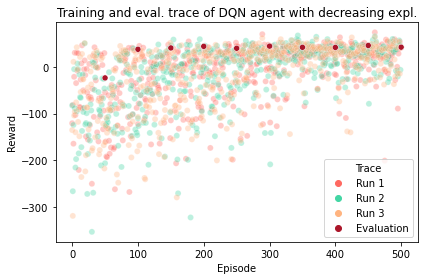

In [187]:
combined_b = create_combined(training_trace_b, eval_trace_b)
save_trace('Q3b-trace.pickle', combined_b)
plt_combined(combined_b, "Training and eval. trace of DQN agent with decreasing expl.")

In [74]:
agent = DQNagent(env_3)
agent.load_model("Q3b_best_model.mdl")
three_example_episodes = [run_episode_simulation(agent,env_3,SEED+i) for i in range(average_over)]

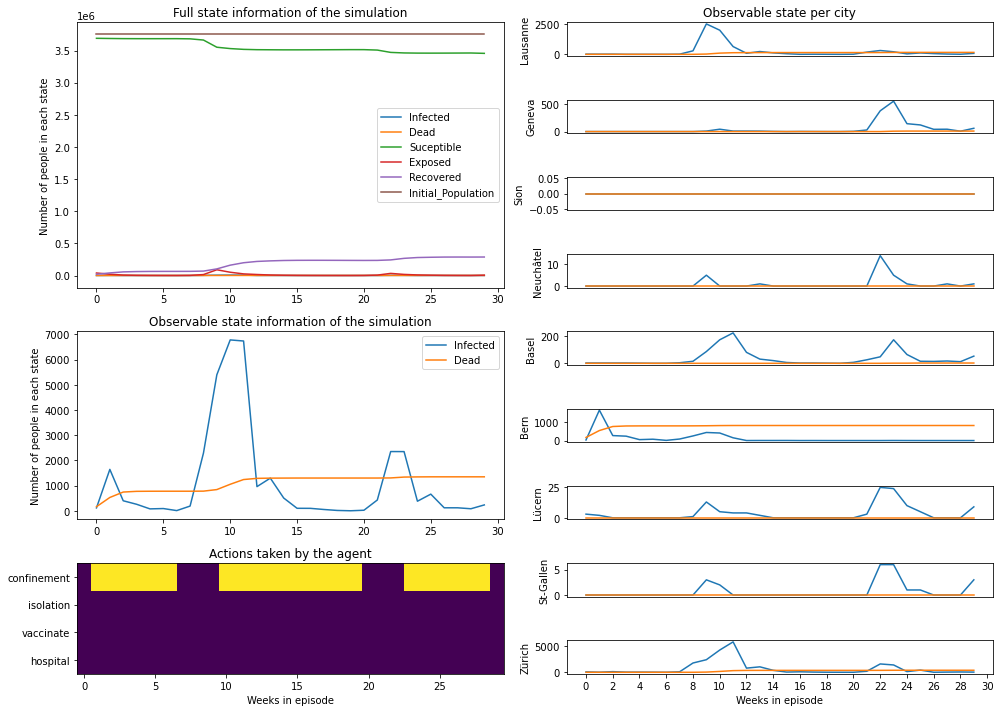

In [75]:
_, _, total, cities, actions = three_example_episodes[2]
plt_toghether(total, cities, actions)

Compare and discuss the results between Q3a and Q3b:

In [38]:
def plt_multi_combined(combined_list, combined_names, title):
    combined = []
    for agent, agent_name in zip(combined_list, combined_names):
        name = pd.DataFrame([agent_name for _ in range(len(agent))], columns=["Agent"])
        combined.append(agent.join(name))
    combined = pd.concat(combined)
    colors = ['#ff6961', '#42d6a4', '#ffb480',  '#59adf6', '#f8f38d', '#08cad1', '#9d94ff', '#c780e8']
    colors = colors[:len(combined[combined['Training run'] != "Evaluation"]['Training run'].unique())]
    ax = sns.scatterplot(data=combined[combined['Training run'] != "Evaluation"], x="Episode", y="Reward", hue="Training run", style="Agent", palette=colors, alpha=0.35)
    ax2 = sns.scatterplot(data=combined[combined['Training run'] == "Evaluation"], x="Episode", y="Reward", hue="Trace", style="Agent", alpha=1.0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

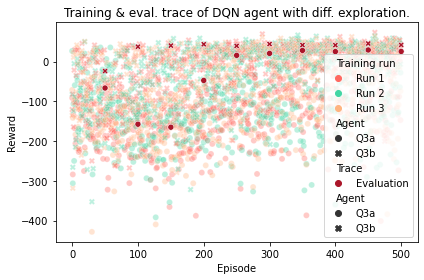

In [216]:
# Plot them together
combined_a = load_trace(name='Q3a-trace.pickle')
combined_b = load_trace(name='Q3b-trace.pickle')
plt_multi_combined([combined_a, combined_b], ["Q3a", "Q3b"], "Training & eval. trace of DQN agent with diff. exploration.")

TODO: Compare and discuss the results between the two different exploration policies. Which policy gets the best results?

### Question 3.c)
Evalutate the best performing policy against Pr. Russo's policy

Running a simulation of 50 enviroments with the DQN agent and with decreasing exploration.

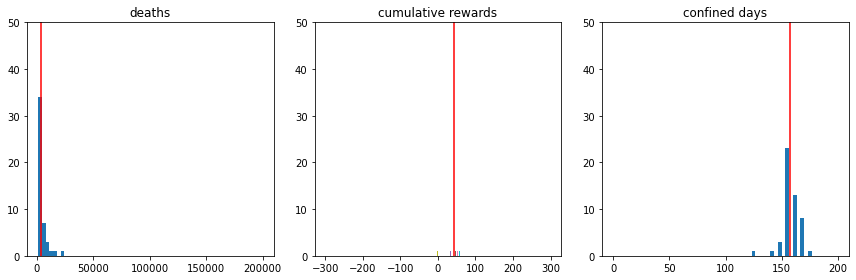

Average death number: 3884.42
Average cumulative reward: 42.563636779785156
Average number of confined days: 157.22


In [79]:
agent = DQNagent(env_3)
agent.load_model("Q3b_best_model.mdl")
# Plot the histograms
hist_plot(agent, env_3, n=50)

TODO: Did the reinforcement learning policy outperform Pr. Russo's policy?



## Question 4 More complex action spaces

### Question 4.1 Toggle-action-space multi-action agent

In [ ]:
# Different learning rate for 4.1 than was suggested, as this seems to make it much much better
# and gets it closer to the other two agents
LR = 10**-4

In [229]:
# Needs a new action space
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    # Get previous actions
    action = dyn.get_action()
    # Update actions (only one action can be toggled at the same time=
    if a == ACTION_CONFINE:
        action['confinement'] = not action['confinement']
    elif a == ACTION_ISOLATE:
        action['isolation'] = not action['isolation']
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = not action['vaccinate']
    elif a == ACTION_HOSPITALIZE:
        action['hospital'] = not action['hospital']
    
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # Create action toggle state
    actionState = torch.Tensor([[*map(float,dyn.get_action().values())]])
    obvSpace = torch.Tensor(np.stack((infected, dead))).to(device).unsqueeze(0)
    return obvSpace, actionState

action_space        =   spaces.Discrete(2)
print(f"sampled action : {action_space.sample()}")

In [ ]:
env_41 = Env(dyn,
            action_space=action_space,
            observation_space=observation_space,
            observation_preprocessor=observation_preprocessor,
            action_preprocessor=action_preprocessor
        )

In [ ]:
# Also needs a new nerual network architecture
class DQN41(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.flatten = nn.Flatten()
        self.input = nn.Linear(n_observations, 64)
        self.layer1 = nn.Linear(64, 32)
        self.layer2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        obvSpace, actionState = x
        obvSpace = obvSpace**0.25
        obvSpace = self.flatten(obvSpace)
        # Combine observations with current toggle state
        x = torch.cat((obvSpace,actionState),axis=1)
        x = F.relu(self.input(x))
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output(x)

In [ ]:
class DQNagent41(Agent):
    def __init__(self,  env:Env, eps=0.7):
        self.env = env
        self.n_actions = env.action_space.n
        # The number of observations are the obs from env and the toggle action space
        # -1 since the space doesn't contain toggle nothing
        self.n_observations = spaces.utils.flatdim(env.observation_space) + self.n_actions - 1
        self.dqnQtheta = DQN41(self.n_observations, self.n_actions).to(device)
        self.dqnQhat = DQN41(self.n_observations, self.n_actions).to(device)
        self.dqnQhat.load_state_dict(self.dqnQtheta.state_dict())
        self.memory = ReplayMemory(MS)
        self.optimizer = optim.AdamW(self.dqnQtheta.parameters(), lr=LR, amsgrad=True)
        self.epsilon = eps

    def load_model(self, savepath):
        loaded_state_dict = torch.load(savepath)    
        self.dqnQtheta.load_state_dict(loaded_state_dict)
        self.dqnQhat.load_state_dict(loaded_state_dict)

    def save_model(self, savepath):
        torch.save(self.dqnQtheta.state_dict(), savepath)
        
    # Following alg. 1 in https://arxiv.org/pdf/1312.5602.pdf
    def optimize_model(self,):
        # Heavily based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
        if len(self.memory) < BS:
            return
        transitions = self.memory.sample(BS)
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = (torch.cat([s[0] for s in batch.next_state
                                                    if s is not None]),
                                torch.cat([s[1] for s in batch.next_state
                                                    if s is not None]))
        
        # Since our state is a tuple of the obs and the toggle states we need to do some zip magic
        state_batch = tuple(map(torch.cat,[*zip(*batch.state)]))
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).to(device)

        # Compute  Q_sigma(sj, aj) for all states.
        state_action_values = self.dqnQtheta(state_batch).gather(1, action_batch)

        # Compute rj + DF * max_a' Q_hat(sj+1, a') for all non-final states,
        # for all final states values are 0
        next_state_values = torch.zeros(BS, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.dqnQhat(non_final_next_states).max(1)[0]
        next_state_values = next_state_values.unsqueeze(1)
        expected_state_action_values = reward_batch + (DF * next_state_values)

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model, where we update Q_0 & Q_hat at the same time
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        torch.manual_seed(SEED)
    
    def act(self, obs):
        # eps greedy choosing
        if random.random() < 1 - self.epsilon:
            # Exploitation
            with torch.no_grad():
                # The unmitigated agent always takes the same action, i.e. do nothing
                containment = self.dqnQtheta(obs) # flatten not necessary bc of nn.Flatten
                # max(1) returns lagest column vector per row, [1] of that the index of it 
                #print(containment,containment.max(1)[1].view(1, 1))
                return containment.max(1)[1].view(1, 1)
        else:
            # Exploration
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

#### Evaluate this new agent

In [ ]:
# Eval trace averaged over n runs, training_trace can be used together
training_trace_41, eval_trace_41 = list(zip(*[run_simulation(DQNagent41(env_41),env_41,SEED, "Q41") for _ in range(average_over)]))

In [ ]:
combined_q41 = create_combined(training_trace_41, eval_trace_41)
save_trace('Q41-trace.pickle', combined_q41)
plt_combined(combined_q41, "Training and evaluation trace of toggle-action-space DQN agent")

Looking at examples of the learned policy:

In [ ]:
agent = DQNagent41(env_41)
agent.load_model("Q41_best_model.mdl")
three_example_episodes_41 = [run_episode_simulation(agent,env_41,SEED+i) for i in range(5)]

In [ ]:
_, _, total, cities, actions = three_example_episodes_41[0]
plt_toghether(total, cities, actions)

TODO interpret this policy

#### Multiple simulations
Running a suimulation of 50 enviroments with the DQN agent of 4.1

In [ ]:
agent = DQNagent41(env_41)
agent.load_model("Q41_best_model.mdl")
# Plot the histograms
hist_plot(agent, env_41, n=50)

### Question 4.2 Factorized Q-values, multi-action agent

In [ ]:
# Different learning rate for these:
LR = 10**-5

In [39]:
# Needs again a new action space
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = {
        'confinement': a[0] == 1, 
        'isolation': a[1] == 1, 
        'hospital': a[2] == 1, 
        'vaccinate': a[3] == 1,
    }
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    obvSpace = torch.Tensor(np.stack((infected, dead))).to(device).unsqueeze(0)
    return obvSpace

action_space        =   spaces.MultiBinary(4)
print(f"sampled action : {action_space.sample()}")

sampled action : [0 0 0 1]


In [40]:
env_42 = Env(dyn,
            action_space=action_space,
            observation_space=observation_space,
            observation_preprocessor=observation_preprocessor,
            action_preprocessor=action_preprocessor
        )

#### Question 4.2.a)
Implementing the new DQN agent

In [41]:
class DQNagent42(Agent):
    def __init__(self,  env:Env, eps=0.7):
        self.env = env
        self.n_observations = spaces.utils.flatdim(env.observation_space)
        self.n_actions = 4*2
        print(f"Creating a DQNagent with n_obs: {self.n_observations} and n_act: {self.n_actions}")
        self.dqnQtheta = DQN(self.n_observations, self.n_actions).to(device)
        self.dqnQhat = DQN(self.n_observations, self.n_actions).to(device)
        self.dqnQhat.load_state_dict(self.dqnQtheta.state_dict())
        self.memory = ReplayMemory(MS)
        self.optimizer = optim.AdamW(self.dqnQtheta.parameters(), lr=LR, amsgrad=True)
        self.epsilon = eps

    def load_model(self, savepath):
        loaded_state_dict = torch.load(savepath)    
        self.dqnQtheta.load_state_dict(loaded_state_dict)
        self.dqnQhat.load_state_dict(loaded_state_dict)

    def save_model(self, savepath):
        torch.save(self.dqnQtheta.state_dict(), savepath)
        
    # Following alg. 1 in https://arxiv.org/pdf/1312.5602.pdf
    def optimize_model(self,):
        # Heavily based on https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
        if len(self.memory) < BS:
            return
        transitions = self.memory.sample(BS)
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action).to(device).view(-1, 4, 1) # should have the form of (BS, 4, 1)
        reward_batch = torch.cat(batch.reward).to(device).squeeze() # should have the form of (BS)

        # Compute  Q_sigma(sj, aj) for all states.
        state_action_values = self.dqnQtheta(state_batch).view(-1, 4, 2) # Shape (BS, 4, 2)
        state_action_values = state_action_values.gather(2, action_batch) # Form of (BS, 4, 1)
        # Q value is defined as the sum of half of the neurons, namely those chosen by the action
        state_action_values = state_action_values.squeeze().sum(dim=1) # Form of (BS) (we sum over the 4 chosen actions)

        # Compute rj + DF * max_a' Q_hat(sj+1, a') for all non-final states,
        # for all final states values are 0
        next_state_values = torch.zeros(BS, device=device) # (BS)
        with torch.no_grad():
            all_q_values = self.dqnQhat(non_final_next_states).view(-1, 4, 2) # (BS, 4, 2)
            # for each neuron pair in all_q_values, take the sum over the max of each two paired neurons
            max_pair_q_values = all_q_values.max(2)[0].sum(dim=1) # (BS, 1)
            next_state_values[non_final_mask] = max_pair_q_values.squeeze() #(BS)
        expected_state_action_values = reward_batch + (DF * next_state_values) # (BS)

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model, where we update Q_0 & Q_hat at the same time
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        torch.manual_seed(SEED)
    
    def act(self, obs):
        # eps greedy choosing
        if random.random() < 1 - self.epsilon:
            # Exploitation
            with torch.no_grad():
                # The unmitigated agent always takes the same action, i.e. do nothing
                multi_pairs = self.dqnQtheta(obs.unsqueeze(0)).view(4,2) # flatten not necessary bc of nn.Flatten
                # multi_pairs contains 4 * 2 neuron pairs, we need to choose for each pair the higher one
                res = multi_pairs.max(1)[1]
                return res
        else:
            # Exploration
            return torch.tensor(self.env.action_space.sample(), device=device, dtype=torch.long)

#### Question 4.2.b)
Evaluating the new agent

In [270]:
# Eval trace averaged over n runs, training_trace can be used together
training_trace_42, eval_trace_42 = list(zip(*[run_simulation(DQNagent42(env_42),env_42,SEED, "Q42") for _ in range(average_over)]))

Creating a DQNagent with n_obs: 126 and n_act: 8


KeyboardInterrupt: 

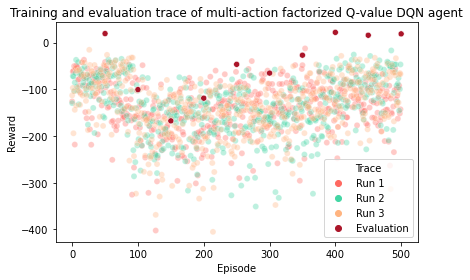

In [234]:
combined_q42 = create_combined(training_trace_42, eval_trace_42)
save_trace('Q42-trace.pickle', combined_q42)
plt_combined(combined_q42, "Training and evaluation trace of multi-action factorized Q-value DQN agent")

TODO check okay
Does your agent sucessfully learn a policy?

Similarly to the simple DQN we can see that this does learn a policy, which can also be seen by the rewards that are achieved until the end of training for the 20 evaluation episodes.

In [235]:
# Plot this policy learning agains Q41
plt_multi_combined([combined_q41, combined_q42], ["Q41", "Q42"], "Training & eval. trace of DQN agent with diff. exploration.")

AttributeError: 'list' object has no attribute 'join'

Comparing the two multi-action agents during training:

As we can see in the above plot: TODO

Record three example episodes with best policy and plot one of them.

In [55]:
agent = DQNagent42(env_42)
agent.load_model("Q42_best_model.mdl")
three_example_episodes_42 = [run_episode_simulation(agent,env_42,SEED+i) for i in range(5)]

Creating a DQNagent with n_obs: 126 and n_act: 8


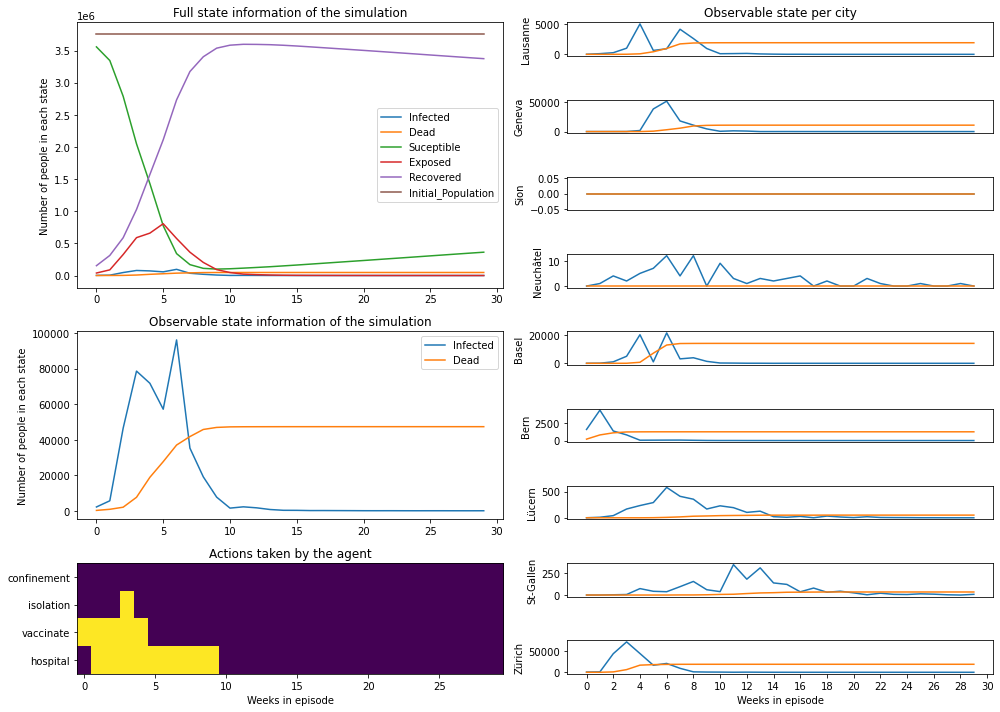

In [57]:
_, _, total, cities, actions = three_example_episodes_42[0]
plt_toghether(total, cities, actions)

TODO: Interpret this policy.

This policy seems to mostly start vaccinating immideatly (but not always on the first week) and then tries to find a balance of cost oh hospital beds and how many people it expects to be infected at once at most.
The latter point seems to coincide with the moment in which total infections drop off (most often around week 9).
Isolation seems to be only used when infections increase above a certain speed or maybe when a subset of the cities start to get infected, because the agent learned that this will top the spread to other cities.

#### Multiple simulations
Running a suimulation of 50 enviroments with the DQN agent of 4.2

Creating a DQNagent with n_obs: 126 and n_act: 8


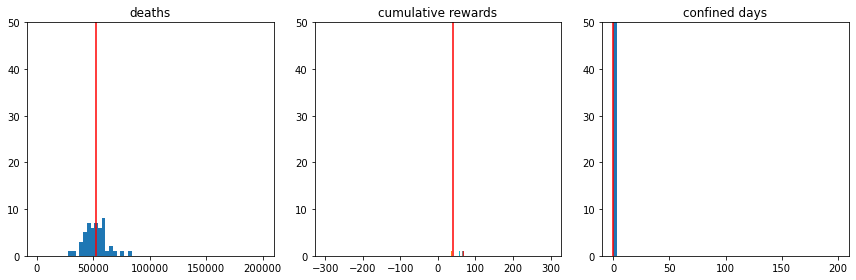

Average death number: 51991.66
Average cumulative reward: 39.697113037109375
Average number of confined days: 0.0


In [46]:
agent = DQNagent42(env_42)
agent.load_model("Q42_best_model.mdl")
# Plot the histograms
hist_plot(agent, env_42, n=50)

TODO: How does this multi-action policy compare to the toggled policy?

#### Question 4.2.c)

TODO: What assumptions does the use of such a factorized-Q-value policy make on the action space?

TODO: Could you think of an action space for which factorizing Q-values would not be suitable? (Discuss)

## Question 5 Wrapping up

### Question 5.a)
Comparing the training behaviors

In [ ]:
# TODO 

TODO discuss the performance differences, what do you observe?
How do the two approaches compare? What performs best? Why?

### Question 5.b)
Comparing policies across 50 simulations.

In [ ]:
# TODO total confined days (lower better)
# TODO total isolation days (lower better)
# TODO total additional hospital bed days (lower better)
# TODO number of total deaths (lower better)
# TODO number of cumulative rewad (higher better)

In [ ]:
# TODO make a table of those values for each policy. Clearly mark the best performing policy with respect to each metric.
# Exclude policies that do not have access to an action from the relevant metrics.

TODO Discuss the table!

### Question 5.c) 
Interpretability of Q-values

For both policies DQN and factor, produce a plot for visualizing the estimated Q-values for one episode.
Run a simulation episode, and plot a heat-map of the evolution of all Q-values with time, with action selections in the y-axis and time (in weeks) in the x axis.
Clearly label which action is associated with which Q-value on the y axis as well as the evolution of time in weeks, provide a color-bar.

In [ ]:
# TODO

TODO Discuss your results.
How interpretable is your policy?

### Question 5.d)
Is cumulative reward an increasing function of the number of actions? (Theory exercise)

TODO You have implemented different policies acting on the exact same environment with a
different number of actions. Is cumulative reward an increasing function of the number of actions?
(In other words, does adding an action always yield a better reward? )